# 3.1 -Penalized Regression - Improving Linear Regression

## Learning objective
1.  Why does linear regression need regularization.
2.  What are some approaches to regularization.
3.  Various formulations of the penalized regression problem
4.  Python examples of some of the methods

## Topics covered
1.  Background on linear regression and its limitations
2.  Forward stepwise regression.
3.  Ridge regression
4.  Code examples and coding problems.

## Readings
http://statweb.stanford.edu/~jtaylo/courses/stats203/notes/penalized.pdf

https://en.wikipedia.org/wiki/Tikhonov_regularization


## Areas where linear regression can be improved
What things would you like to fix about linear regression?  For one thing you might figure out a way to relax the "linear" feature.  You'll see how to do that next week.  Linear regression sometimes overfits the problem.  Adding a coefficient penalty to the formulation of the linear regression problem gives you a way to modulate the complexity of the models produced by linear regression in order to match the richness of the problem and the depth of the data. This lecture will show you how that's accomplished and will give you some alternative approaches in order to cultivate your intuition about how they work.  

## In-class questions
1.  What is overfitting?
2.  How can you measure overfitting?
3. How can you control overfitting?

## Controlling overfit with subset selection
Overfitting linear regression is most severe when there are too many attributes for the amount of data that comes with the problem.  A quick guage that I frequently use is the "aspect ration" of the data set - the ratio of the number of attributes to the number of training examples.  Think of that as being the number of columns of data divided by the number of rows.  Overfitting is less likely with a tall skinny data matrix than with a short wide one.  If the problem is too many attributes, then throw some away.  Subset selection turns this observation into a design process.  The problem with throwing away attributes is to determine how many and which ones.  

Best subset selection takes the following approach.  For every possible size of subset from 1 up to the full number of available attributes determine the best subset of that size.  The quality of the subset is determined by how well the resulting model performs on out of sample data.  The process would be:  Start with a single attribute.  Determine which attribute gives the best performance.  The result is the best subset of size 1.  Then move to size 2 and test every subset of exactly 2 attributes to see which subset is best.  As you can imagine this works okay if you don't have too many attributes, but it quickly becomes impractical to evaluate.  

Forward stepwise subset selection is a hueristic approach to subset selection that is more practical.  Forward stepwise subset selection builds the subsets iteratively.  It starts by finding the best single attribute.  Instead of finding the very best subset of two, it keeps the first attribute that was the best single attribute and then searches the remaining attributes to determine what to pick for the second one.  The process continues in this way until all of the attributes are selected.  The code snip below shows this best forward stepwise subset selection.  

[0.72342592551162777, 0.68609931528371959, 0.67343650334202776, 0.66770332138977961, 0.66225585685222732, 0.65900047541546258, 0.65727172061430761, 0.65709058062076975, 0.65699930964461384, 0.6575818940043473, 0.65739098690113384]


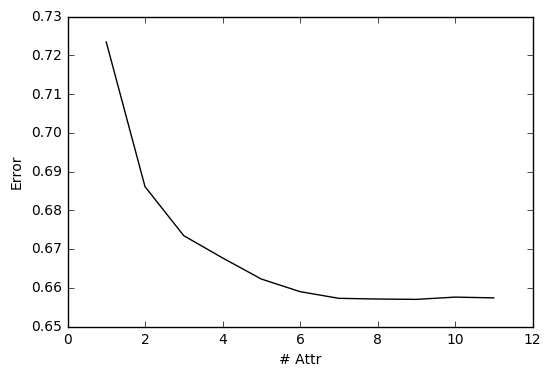

Best # of Attr =   9


In [1]:
__author__ = 'mike-bowles'
import urllib2
import numpy as np
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

def xattrSelect(x, idxSet):
    #takes X matrix as list of list and returns subset containing columns in idxSet
    xOut = []
    for row in x:
        xOut.append([row[i] for i in idxSet])
    return(xOut)

#read data
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib2.urlopen(target_url)
x = []
labels = []
names = []
firstLine = True
for row in data:
    if firstLine:
        names = row.strip().split(";")
        firstLine = False
    else:
        rowSplit = row.strip().split(";")
        labels.append(float(rowSplit[-1]))
        rowSplit.pop()
        floatRow = [float(num) for num in rowSplit]
        x.append(floatRow)

#training and test sets
indices = range(len(x))
xTest = [x[i] for i in indices if i%3 == 0 ]
xTrain = [x[i] for i in indices if i%3 != 0 ]
labelsTest = [labels[i] for i in indices if i%3 == 0]
labelsTrain = [labels[i] for i in indices if i%3 != 0]

#build list of attributes one-at-a-time - starting with empty
attrList = []
attrIdx = range(len(x[1]))
indexSet = set(attrIdx)
indexSeq = []
oosError = []

for i in attrIdx:
    #find attributes not already being used
    attSet = set(attrList)
    attTrySet = indexSet - attSet
    attTry = [ii for ii in attTrySet]

    errorList = []
    attTemp = []

    #try each attribute to see which one gives least oos error
    for iTry in attTry:
        attTemp = [] + attrList
        attTemp.append(iTry)
        #use attTemp to form training and testing sub matrices as list of lists
        xTrainTemp = xattrSelect(xTrain, attTemp)
        xTestTemp = xattrSelect(xTest, attTemp)
        #form into numpy arrays
        xTr = np.array(xTrainTemp); yTr = np.array(labelsTrain); xTe = np.array(xTestTemp); yTe = np.array(labelsTest)
        #use sci-kit learn linear regression
        wineQModel = linear_model.LinearRegression()
        wineQModel.fit(xTr,yTr)
        #use trained model to generate prediction and calculate rmsError
        rmsError = np.linalg.norm((yTe-wineQModel.predict(xTe)), 2)/sqrt(len(yTe))
        errorList.append(rmsError)
        attTemp = []

    iBest = np.argmin(errorList)
    attrList.append(attTry[iBest])
    oosError.append(errorList[iBest])
    
#print the error
print oosError
    
#Plot error versus number of attributes
idx = range(1, len(oosError)+1)
plt.plot(idx, oosError, 'k')
plt.xlabel('# Attr')
plt.ylabel('Error')
plt.show()

print 'Best # of Attr =  ', oosError.index(min(oosError)) + 1


## 3.1 Lab exercise 1.  
1.  Modify the code above for the breast cancer prognosis data set 
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29 
How will you deal with the binary labels?  


## Ridge Regression
Ridge regression is a penalized linear regression method.  To help cultivate your intuition about penalty methods you can relate them to the best subset selections methods discussed above.  As you saw, best subset selection incorporates a series of constraints on how many attributes can be used in the model.  Penalty methods also constrain the solutions.  Instead of constraining the number of attributes, penalty methods constrain the total amount of coefficient that can be used across all of the attributes.  It's okay to use all of the attributes as long as not much of any one is used.  

Here's how the ridge regression problem is folmulated.  Suppose that the labels for your regression problem are $y_i$ and the row of attributes associated with these labels are $x_i$.  A linear model relating the attributes to the labels can be specified with a vector of weights $w$ whose dimension matches the dimension of the attribute vectors and a bias $b$.  Suppose that the total number of instances is $M$.  Then the linear regression problem is to find the weight vector $w^*$ and the bias $b^*$ satisfying 

$w^*, b^* = argmin_{w, b} \frac1M \sum_{i=1}^M (y_i - (b + x_i w^T))^2$

The best values for the weights and bias ($w^* and b^*$) are the ones that minimize the mean squared error.  The ridge regression formulation adds a weight penalty to this formulation.  For ridge regression the best values satisfy

$w^*, b^* = argmin_{w, b} \frac1M \sum_{i=1}^M (y_i - (b + x_i w^T))^2  + \alpha ww^T$

The only difference in the ridge formulation and the ordinary least squares formulation is the last term on the right hand side of this equation.  The last term is a penalty term that adds the sum of the squares of the weights multiplied by a parameter alpha.  Notice that if $\alpha = 0.0$ then the equation becomes the same as ordinary least squares.  If $\alpha$ becomes very large then $w$ has to become very small so that only the bias term $b$ is available to approximate $y_i$.  For large $\alpha$ the solution to the optimization problem becomes independent of the $x_i's$.  

The parameter $\alpha$ provides a ways to modulate the complexity of the resulting linear model in order to match the problem and the amount of data available.  The code snip below illustrates how this works.  

Error             alph
(0.65957881763424575, 1.0)
(0.65786109188085917, 0.1)
(0.65761721446402432, 0.010000000000000002)
(0.65752164826417558, 0.0010000000000000002)
(0.65741906801092931, 0.00010000000000000002)
(0.65739416288512531, 1.0000000000000003e-05)
(0.65739130871558582, 1.0000000000000004e-06)
(0.65739101912535514, 1.0000000000000004e-07)
(0.65739099012398428, 1.0000000000000005e-08)


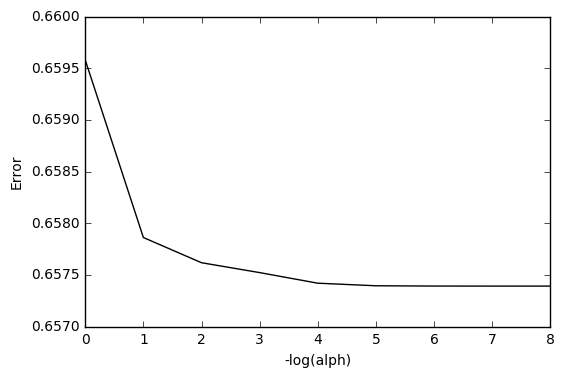

In [2]:
__author__ = 'mike-bowles'

import urllib2
import numpy as np
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

#read data into iterable
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib2.urlopen(target_url)

xList = []
yList = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.strip().split(";")
        #put labels in separate array
        yList.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

#divide attributes and labels into training and test sets
indices = range(len(xList))
xListTest = [xList[i] for i in indices if i%3 == 0 ]
xListTrain = [xList[i] for i in indices if i%3 != 0 ]
yListTest = [yList[i] for i in indices if i%3 == 0]
yListTrain = [yList[i] for i in indices if i%3 != 0]

xTrain = np.array(xListTrain); yTrain = np.array(yListTrain); xTest = np.array(xListTest); yTest = np.array(yListTest)

alphaList = [0.1**i for i in [0,1, 2, 3, 4, 5, 6, 7, 8]]

rmsError = []
for alph in alphaList:
    wineRidgeModel = linear_model.Ridge(alpha=alph)
    wineRidgeModel.fit(xTrain, yTrain)
    rmsError.append(np.linalg.norm((yTest-wineRidgeModel.predict(xTest)), 2)/sqrt(len(yTest)))

print("Error             alph")
for i in range(len(rmsError)):
    print(rmsError[i], alphaList[i])

#plot curve of out-of-sample error versus alpha
x = range(len(rmsError))
plt.plot(x, rmsError, 'k')
plt.xlabel('-log(alph)')
plt.ylabel('Error')
plt.show()

## Lab exercise 2.
Solve the breast cancer prognosis problem using one the the sklearn packages listed below:  
    
linear_model.Ridge([alpha, fit_intercept, ...]) 	Linear least squares with l2 regularization.

linear_model.RidgeClassifier([alpha, ...]) 	Classifier using Ridge regression.

linear_model.RidgeClassifierCV([alphas, ...]) 	Ridge classifier with built-in cross-validation.

linear_model.RidgeCV([alphas, ...]) 	Ridge regression with built-in cross-validation.

1.  You can use the ridge version of these packages as you saw used in the example above.  Since this is a classification problem, you can also use a classifier version.  If you're feeling adventuresome you can used one of the versions that includes cross-validation'.  
2.  Rank the variables in your linear solution in order of their importance.  